In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
# set path/seeds
sys.path.append('../')
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# %matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Flatten, BatchNormalization
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.optimizers import Adam

# custom imports
from utils.custom_keras import toggle_train, all_layers_train, ROC_Eval, ROC_Eval_Full
from utils.metrics import accuracy
from utils.metrics import columnwise_auc


model_name = "LSTM_glove6b200d_reg_logged"
weights_path = model_name + ".hdf5"
submission_path = "SUB_" + model_name + ".csv"
eval_path = "EVAL_" + model_name + ".csv"

# how much training data to use (comment out train.sample line below for all and change this
# to 1)
percent_data = 1

model_names = []
perc_datas = []
optimizer_log = 'adam'    # just for logging purposes only
optimizer_list = []
learning_rates = []
batch_sizes = []
epoch_list = []
epoch_times = []
train_losses = []
val_losses = []
mean_train_aucs = []
mean_val_aucs, tox_aucs, s_tox_aucs = [], [], []
obsc_aucs, thr_aucs, insu_aucs, id_h_aucs = [], [], [], []

# init eval file
eval_file = eval_path

# delete if it exists (THIS IS AN OPTION, COULD DELTETE)
try:
    os.remove(eval_file)
except OSError:
    pass

if not os.path.isfile(eval_file):
    with open(eval_file, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['model_name','perc_data','optimizer',
                         'lr_log','batch_size','epoch_num', 'epoch_time_mins',
                         'train_loss', 'val_loss', 'mean_train_auc', 
                         'mean_val_auc', 'toxic_auc','s_toxic_auc','obscene_auc',
                         'threat_auc', 'insult_auc', 'id_hate_auc'])

# get data
train = pd.read_csv('../../data/train.csv')

# train cutdown (just for testing purposes, can cut down amount of data here)
# train = train.sample(frac=percent_data, random_state=42)

# seperate classes
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values


## CREATE MY SPLIT HERE
# X_train, X_test, y_train, y_test= train_test_split(train, y, test_size = 0.1, 
#                                                 random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15,
                                                 random_state=42)

list_sentences_train = X_train["comment_text"]
list_sentences_val = X_val["comment_text"]
#list_sentences_test = X_test["comment_text"]

# tokenize/index
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_val = tokenizer.texts_to_sequences(list_sentences_val)
#list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

# get single sequence length
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_val = pad_sequences(list_tokenized_val, maxlen=maxlen)
#X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)


# get gembeddings and read into a dict (word: vector)
# then use the embeddings to make embedding matrix, random init for ones not in vocab
embedding_file = "../glove.6B.200d.txt"
embed_size = 200

embeddings_index = pd.read_table(embedding_file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)


all_embs = np.stack(embeddings_index.values)
emb_mean,emb_std = all_embs.mean(), all_embs.std()
word_index = tokenizer.word_index
nb_words = min(len(word_index), max_features)

# init with random ones for words not seen
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        


# model building

# first iteration, embeddings train = False, train for 2 epochs
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier
x = Embedding(max_features, embed_size, weights=[embedding_matrix],
              name = 'embedding', trainable=False)(inp)
x = LSTM(60, return_sequences=True, name='lstm_layer',
         dropout=0.1, recurrent_dropout=0.1,
          kernel_regularizer=regularizers.l2(0.001),
          bias_regularizer=regularizers.l2(0.001))(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(70, activation="relu",
          kernel_regularizer=regularizers.l2(0.001),
          bias_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
lr1 = 0.001
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr1),
                  metrics=['accuracy'])
model.summary()


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Te

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 200)          4000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           62640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 70)                4270      
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
__________

In [2]:
# training
batch_size = 512
epochs = 2

# call backs
es = EarlyStopping('val_loss', patience=15, mode="min")
msave = ModelCheckpoint(weights_path, save_best_only=True)
roc = ROC_Eval_Full(X_t, y_train, X_val, y_val)

# train everything but embedding
hist = model.fit(X_t,y_train, batch_size=batch_size, epochs=epochs,
          shuffle=True, callbacks=[es, msave, roc] , validation_data=(X_val, y_val))

# book keeping for logging
for i in range(epochs):
    model_names.append(model_name)
    perc_datas.append(percent_data)
    optimizer_list.append(optimizer_log)
    epoch_list.append(i)
    batch_sizes.append(batch_size)
    learning_rates.append(lr1)
    
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
times = roc.times
auc_train = roc.auc_train
aucs_val = roc.aucs_val

for j in times:
    epoch_times.append(j)
for q in auc_train:
    mean_train_aucs.append(q)
for z in aucs_val:
    mean_val_aucs.append(z[0])
    tox_aucs.append(z[1])
    s_tox_aucs.append(z[2])
    obsc_aucs.append(z[3])
    thr_aucs.append(z[4])
    insu_aucs.append(z[5])
    id_h_aucs.append(z[6])
for w in train_loss:
    train_losses.append(w)
for k in val_loss:
    val_losses.append(k)
    

# # train only the embedding
# model = toggle_train(model)
# model.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])
# model.summary()
# model.fit(X_t,y_train, batch_size=batch_size, epochs=1,
#           shuffle=True) # callbacks=callbacks , validation_data=(X_val, y_val)


# train everything
roc2 = ROC_Eval_Full(X_t, y_train, X_val, y_val)
model = all_layers_train(model)
lr2 = 0.0001
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr2),
                  metrics=['accuracy'])
model.summary()
epochs2 = 20
hist2 = model.fit(X_t,y_train, batch_size=batch_size, epochs=epochs2,
          shuffle=True, callbacks=[es, msave, roc2] , validation_data=(X_val, y_val))


# book keeping for logging
for i in range(epochs2):
    model_names.append(model_name)
    perc_datas.append(percent_data)
    optimizer_list.append(optimizer_log)
    new = i + epochs
    epoch_list.append(new)
    batch_sizes.append(batch_size)
    learning_rates.append(lr2)
    
train_loss2 = hist2.history['loss']
val_loss2 = hist2.history['val_loss']
times2 = roc2.times
auc_train2 = roc2.auc_train
aucs_val2 = roc2.aucs_val

for j in times2:
    epoch_times.append(j)
for q in auc_train2:
    mean_train_aucs.append(q)
for z in aucs_val2:
    mean_val_aucs.append(z[0])
    tox_aucs.append(z[1])
    s_tox_aucs.append(z[2])
    obsc_aucs.append(z[3])
    thr_aucs.append(z[4])
    insu_aucs.append(z[5])
    id_h_aucs.append(z[6])
for w in train_loss2:
    train_losses.append(w)
for k in val_loss2:
    val_losses.append(k)

# model.save(weights_path)


Train on 25849 samples, validate on 2873 samples
Epoch 1/2
25600/25849 [============================>.] - ETA: 0s - loss: 0.6406 - acc: 0.8638
 ROC-AUC - score: 0.524981
25849/25849 [==============================] - 93s 4ms/step - loss: 0.6383 - acc: 0.8648 - val_loss: 0.4106 - val_acc: 0.9612
Epoch 2/2
25600/25849 [============================>.] - ETA: 0s - loss: 0.3416 - acc: 0.9625
 ROC-AUC - score: 0.793080
25849/25849 [==============================] - 92s 4ms/step - loss: 0.3415 - acc: 0.9624 - val_loss: 0.2905 - val_acc: 0.9616
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 200)          4000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           62640 

In [3]:


print(model_names)
print(perc_datas)
print(optimizer_list)
print(learning_rates)
print(batch_sizes)
print(epoch_list)
print(epoch_times)
print(train_losses)
print(val_losses)
print(mean_train_aucs)
print(mean_val_aucs)
print(tox_aucs)
print(s_tox_aucs)
print(obsc_aucs)
print(thr_aucs)
print(insu_aucs)
print(id_h_aucs)

print(len(model_names))
print(len(perc_datas))
print(len(optimizer_list))
print(len(learning_rates))
print(len(batch_sizes))
print(len(epoch_list))
print(len(epoch_times))
print(len(train_losses))
print(len(val_losses))
print(len(mean_train_aucs))
print(len(mean_val_aucs))
print(len(tox_aucs))
print(len(s_tox_aucs))
print(len(obsc_aucs))
print(len(thr_aucs))
print(len(insu_aucs))
print(len(id_h_aucs))

['LSTM_glove6b200d_reg_logged', 'LSTM_glove6b200d_reg_logged', 'LSTM_glove6b200d_reg_logged', 'LSTM_glove6b200d_reg_logged', 'LSTM_glove6b200d_reg_logged', 'LSTM_glove6b200d_reg_logged', 'LSTM_glove6b200d_reg_logged', 'LSTM_glove6b200d_reg_logged']
[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
['adam', 'adam', 'adam', 'adam', 'adam', 'adam', 'adam', 'adam']
[0.001, 0.001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
[512, 512, 512, 512, 512, 512, 512, 512]
[0, 1, 2, 3, 4, 5, 6, 7]
[0.2964805324872335, 0.28572895129521686, 0.3444209694862366, 0.3319272796312968, 0.3313249866167704, 0.33138169050216676, 0.33039979537328085, 0.33031392892201744]
[0.6382755220946346, 0.3414634275198435, 0.2884818604086634, 0.27481309018022915, 0.2608974750972199, 0.2499677379696995, 0.238442278992895, 0.22851426757506335]
[0.4106437417633476, 0.29051518678831134, 0.27651796889064456, 0.2641846943650559, 0.2531518516818945, 0.24268885025300094, 0.2327957859686182, 0.2238625100202109]
[0.5072031377997744, 0.77

In [4]:

with open(eval_file, "a") as f:
    writer = csv.writer(f)
    for i in range(len(model_names)):
        writer.writerow([model_names[i], perc_datas[i],optimizer_list[i],
                        learning_rates[i], batch_sizes[i], epoch_list[i],
                        epoch_times[i], train_losses[i], val_losses[i],
                        mean_train_aucs[i], mean_val_aucs[i], tox_aucs[i],
                        s_tox_aucs[i], obsc_aucs[i], thr_aucs[i], insu_aucs[i],
                        id_h_aucs[i]])
        

        


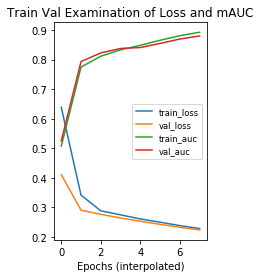

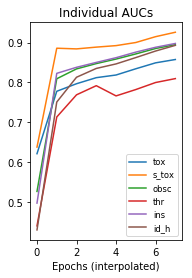

In [7]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')

df = pd.read_csv(eval_file)
#print(df.head(20))

x = np.arange(len(model_names))

plt.subplot(1,2,1)
plt.plot(x, df['train_loss'])
plt.plot(x, df['val_loss'])
plt.plot(x, df['mean_train_auc'])
plt.plot(x, df['mean_val_auc'])
plt.legend(['train_loss', 'val_loss', 'train_auc', 'val_auc'], prop=fontP)
plt.xlabel('Epochs (interpolated)')
plt.title('Train Val Examination of Loss and mAUC')

#plt.show()
plt.savefig(model_name + '_loss_mAUC.png')

plt.subplot(1,2,2)
plt.plot(x, df['toxic_auc'])
plt.plot(x, df['s_toxic_auc'])
plt.plot(x, df['obscene_auc'])
plt.plot(x, df['threat_auc'])
plt.plot(x, df['insult_auc'])
plt.plot(x, df['id_hate_auc'])
plt.legend(['tox', 's_tox', 'obsc', 'thr', 'ins', 'id_h'], prop=fontP)
plt.xlabel('Epochs (interpolated)')
plt.title('Individual AUCs')


#plt.show()
plt.savefig(model_name + 'Individual_AUCs.png')


In [ ]:
# test on test data here X_te, y_test   Need to do the columwise AUC here and acc


probs = model.predict(X_te)


acc = accuracy(y_test, probs)
print("acc", acc)
mean_col_auc = columnwise_auc(y_test, probs)
print("mean col", mean_col_auc)
    


In [ ]:
# submission prediction
model.load_weights(weights_path)

sub = pd.read_csv('../../data/test.csv')
list_tokenized_sub = tokenizer.texts_to_sequences(sub["comment_text"])
X_sub = pad_sequences(list_tokenized_sub, maxlen=maxlen)

y_sub = model.predict(X_sub)

sample_submission = pd.read_csv("../../data/sample_submission.csv")
sample_submission[list_classes] = y_sub


sample_submission.to_csv(submission_path, index=False)